## Problem Definition and topic Importance

### 📈 Financial Relevance of Sentiment Classification on Amazon Reviews

In this assignment, I have used Amazon large review data on their products. Those are rated from 1-5, 5 is the top review. 
However, to align this with meaningful financial application, we focused on indetifying the people's sentiment on amazon product which may lead to generated proper indicator on how the Amazon as a company would perform such as,

1. The consumers sentiment (whether positive or negative or neutral) as an indicator for financial outcome of the company itself. Which indirectly helps to predict the stock trends and income growth,

2. Institutional investors increasingly rely on alternative data foe the market analysis, therefore this information would be used to Feed into quantitative trading strategies to enhance the Enhance credit risk models.

3. Market Timing for Consumer Goods Stocks: we can apply our model to analyze reviews for consumer discretionary companies (like Nike, Sony, or Lululemon) : Positive sentiment clusters may signal when a company is about to experience a surge in sales.

4. Automating Research and Decision-Making: Reduce manual review time. Instead of reading thousands of reviews, analysts get a high-level sentiment summary. Time has direct impact on money. This solution makes impact to save huge time.




### 🎯 Sentiment Mapping Strategy

To align the model's output with real-world financial interpretation, we chose to focus on high-level sentiment categories — representing the general public's opinion on Amazon products.

#### Why Simplify to 3 Classes?

Mapping the original 1–5 star review scale into three broader sentiment categories allows:

- Easier interpretation by external stakeholders (investors, analysts, business strategists)
- Improved model generalization and training efficiency
- Better alignment with traditional sentiment analysis practices in finance

#### 📊 Mapping Logic

To achieve this, we re-labeled the review scores as follows:

- ⭐️ 1 & 2 → **Negative**
- ⭐️ 3 → **Neutral**
- ⭐️ 4 & 5 → **Positive**

This transformation enables the model to focus on meaningful distinctions in sentiment and produce outputs that can be directly used in downstream financial applications (e.g., forecasting demand or stock performance based on consumer feedback).


## Analyze Dataset

### Import Libraries and Dataset

We import the dataset directly from Huggingface library

In [123]:
from datasets import load_dataset
import pandas as pd
import re
import matplotlib.pyplot as plt

ds = load_dataset("yassiracharki/Amazon_Reviews_for_Sentiment_Analysis_fine_grained_5_classes")


In [124]:
# Convert the 'train' split to a pandas DataFrame
df_train = ds['train'].to_pandas()
df_test = ds['test'].to_pandas()

### Explore the Dataset

In [125]:
df_train.head(2)

,class_index,review_title,review_text
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...


In [126]:
df_test.head(2)

,class_index,review_title,review_text
0,1,mens ultrasheer,"This model may be ok for sedentary types, but ..."
1,4,Surprisingly delightful,This is a fast read filled with unexpected hum...


In [127]:
# Check dataset size
print(f"Number of samples: {len(df_train)}")

# Check for missing values
print(df_train.isnull().sum())

# Check class distribution
print(df_train['class_index'].value_counts(normalize=True))


Number of samples: 3000000
class_index       0
review_title    188
review_text       0
dtype: int64
class_index
3    0.2
5    0.2
4    0.2
1    0.2
2    0.2
Name: proportion, dtype: float64


There are 3 million data points. Importantly there are no missing values in class or text. The 188 missing values in title section will not harmfull for our model.

In [128]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   class_index   650000 non-null  int64 
 1   review_title  649974 non-null  object
 2   review_text   650000 non-null  object
dtypes: int64(1), object(2)
memory usage: 14.9+ MB


The test dataset gas 650000 data points, which we will keep for the testing the model.

## Cleaning and Preprocessing

In [ ]:
# Drop rows with missing review_text or class_index
df_train = df_train.dropna(subset=['review_text', 'class_index'])

# fill missing titles with empty string
df_train['review_title'] = df_train['review_title'].fillna("")
df_test['review_title'] = df_test['review_title'].fillna("")


# Combine title and text into one column
df_train['text'] = df_train['review_title'] + ": " + df_train['review_text']
df_test['text'] = df_test['review_title'] + ": " + df_test['review_text']

# Basic text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-z0-9\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

# Apply cleaning
df_train['clean_text'] = df_train['text'].apply(clean_text)
df_test['clean_text'] = df_test['text'].apply(clean_text)


In [130]:
# drop review_title and review_text and text
df_train = df_train.drop(columns=['review_title', 'review_text', 'text'])
df_test = df_test.drop(columns=['review_title', 'review_text', 'text'])

# rename class_index to label and clean_text to text
df_train = df_train.rename(columns={'class_index': 'label', 'clean_text': 'text'})
df_test = df_test.rename(columns={'class_index': 'label', 'clean_text': 'text'})

In [131]:
# convert all labels to int and text to str
df_train['label'] = df_train['label'].astype(int)
df_test['label'] = df_test['label'].astype(int)

df_train['text'] = df_train['text'].astype(str)
df_test['text'] = df_test['text'].astype(str)

Converted all the contexts into strings and all labels into integers to improve the robustness

Investigated the missing values, and replaces missing values with empty strings to overcome errors when modeling, and performed some basic cleanings like punctuations, extra spaces and URLS removals.

In [132]:
# find the length of longest review_text
def find_max_length(df, column):
    max_length = df[column].apply(lambda x: len(re.findall(r'\w+', x))).max()
    return max_length
max_length_train_clean_text = find_max_length(df_train, 'text')
print(f"Max length of clean_text in train: {max_length_train_clean_text}")

Max length of clean_text in train: 441


Therefore minimum 512 length of context window is required in our transformer to process each datapoint alone

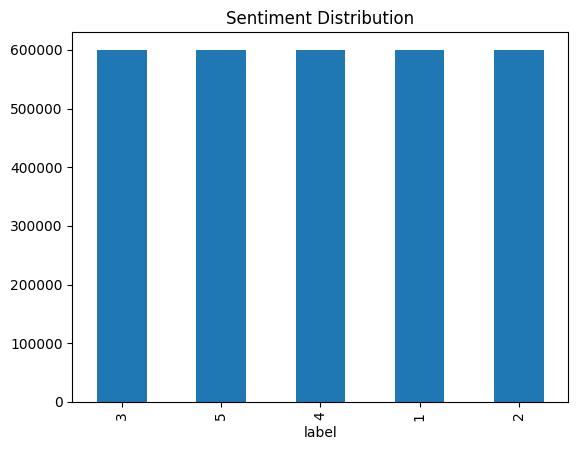

In [133]:
df_train['label'].value_counts().plot(kind='bar', title='Sentiment Distribution')
plt.show()


The dataset consists of review scores, which is 5 different values form 1-5, 5 is the best. And those are well distributed closely 20% percent for each level

### Transform the Dataset into sentiments

As mentioned earlier, the goal is to get highlevel understanding, therefore the 5 classes reduced to 3 classes based on sentiments. 

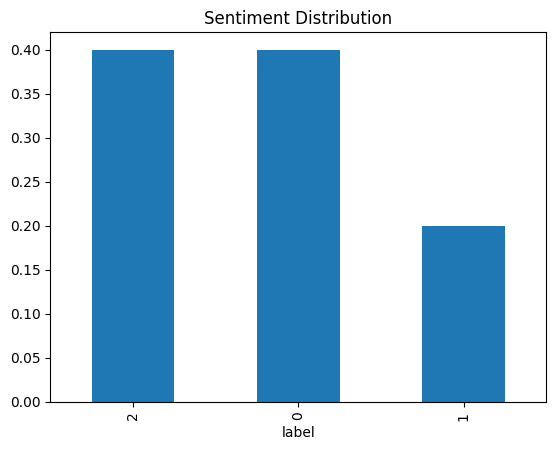

In [134]:
# label 1,2 as positive, 3 as neutral, and 4,5 as negative 
"""
    1: negative -> 0
    2: negative -> 0
    3: neutral -> 1
    4: positive -> 2
    5: positive -> 2
"""
# 
def map_labels(label):
    if label in [4, 5]:
        return 2  # positive
    elif label == 3:
        return 1  # neutral
    else:
        return 0  # negative
df_train['label'] = df_train['label'].map(map_labels)
df_test['label'] = df_test['label'].map(map_labels)
# Check the new distribution
df_train['label'].value_counts(normalize=True).plot(kind='bar', title='Sentiment Distribution')
plt.show()

Transforemd distribution seems unbalanced, which can lead to the model to biases results, therefore we cut down the positives and negatives by 50%
Eventhough the 50% is large portion, still we have 1.8 million data points which is feasible amount to fine tune a language model

In [135]:
# print n of rows in each class in train and test
print("Train class distribution:")
print(df_train['label'].value_counts())
print("Test class distribution:")
print(df_test['label'].value_counts())

Train class distribution:
label
2    1200000
0    1200000
1     600000
Name: count, dtype: int64
Test class distribution:
label
0    260000
2    260000
1    130000
Name: count, dtype: int64


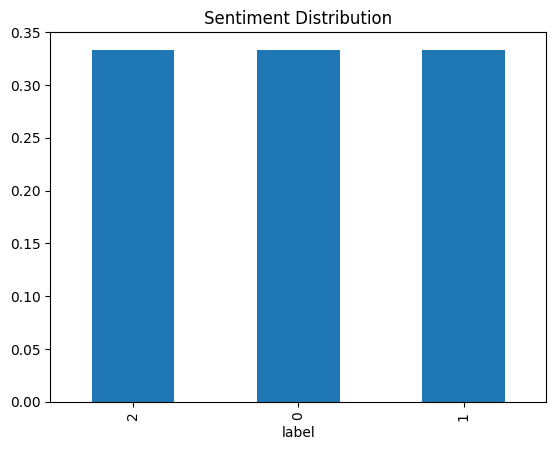

In [136]:
# make label 1 randomly 600000 and -1 randomly 600000
df_train_pos = df_train[df_train['label'] == 2].sample(n=600000, random_state=42)
df_train_neg = df_train[df_train['label'] == 0].sample(n=600000, random_state=42)
df_train_neutral = df_train[df_train['label'] == 1]
df_train = pd.concat([df_train_pos, df_train_neg, df_train_neutral])
# Check the new distribution
df_train['label'].value_counts(normalize=True).plot(kind='bar', title='Sentiment Distribution')
plt.show()

In [137]:
# make label 1 randomly 600000 and -1 randomly 600000
df_test_pos = df_test[df_test['label'] == 2].sample(n=130000, random_state=42)
df_test_neg = df_test[df_test['label'] == 0].sample(n=130000, random_state=42)
df_test_neutral = df_test[df_test['label'] == 1]
df_test = pd.concat([df_test_pos, df_test_neg, df_test_neutral])

In [138]:
# print n of rows in each class in train and test
print("Train class distribution:")
print(df_train['label'].value_counts())
print("Test class distribution:")
print(df_test['label'].value_counts())

Train class distribution:
label
2    600000
0    600000
1    600000
Name: count, dtype: int64
Test class distribution:
label
2    130000
0    130000
1    130000
Name: count, dtype: int64


Finally we have obtained very balanced test and train dataset for out training and validation. We save these dataset as csv file which is convinient for further steps.

In [139]:
# save the dataframes to csv
df_train.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)

## Try BERT based classification model to classify amazon reviews

### 🧠 Why BERT?

BERT is a transformer architecture which is trained on large text corpus, however the archotecture is special. The attention layers are not causal attention. They measure the connection within all input tokens in both direction (Bi-direction)
Therefore, this type of architectures are used to represent the text sequences than generative tasks. And these models are much popular with fine tuning for downstream tasks. As this models have already embedded with some knowledge, so by using task specific head such as classification, we can easily obtain better performance.

In our particular case, we are classifying the text sequences into sentiments, therefore buy using 3 class classification head on top of the encoder layer would be sufficient.

In [6]:
from transformers import BertModel, BertTokenizer
bert = BertModel.from_pretrained("bert-base-uncased")
print(bert)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

Based on the model configs and the architecture there are few observations.
1. the embedding lookup table is 30522x768, which means this accepts 50265 of discrete tokens and embedded them with the 768 vector.
2. Max poisitional embedding is 512, therefore it implies that the maximum input tokens is 512 for the model, at least for the existing traiing configs it followed.
3. 12 encoder transformer blocks which transform the input embeddings through 12 levels


To input the raw data into model, we need to use a tokenizer to represent our natural language inputs by integer. In BERT, they use particular encoding which is converting the input text into integers of discrete set.
So after taking the raw text, the tokenizer outputs the sequence of integers, which become thr input to the Language Model

In [8]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenizer("Hello world")

{'input_ids': [101, 7592, 2088, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

In this assignment, we do not initiate all the parameters (weights) of the models.

But we train the model on top of existing weights while adding a classification linear layer on hidden outputs.


In [9]:
import torch
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
inputs.input_ids, inputs.input_ids.shape

(tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]]),
 torch.Size([1, 8]))

We convert the integer list intp pytorch tensor, as the model is built with pytorch and those accepts only tensor inputs.
Tensors are similar to multi deimensional arrays, which are optimized for numerical methods and gpu

In [24]:
# n of paramas
print(f"Number of parameters: {bert.num_parameters()}M")
outputs = bert(**inputs)


Number of parameters: 109482240M


We can see the bert model already has 109.48 parameters. 

In [14]:
last_hidden_state_shape = outputs.last_hidden_state.shape
pooler_output_shape = outputs.pooler_output.shape
print(f"Last hidden state shape: {last_hidden_state_shape}")
print(f"Pooler output shape: {pooler_output_shape}")

Last hidden state shape: torch.Size([1, 8, 768])
Pooler output shape: torch.Size([1, 768])


As we can see the models final layers, the hidden states are one hidden state representation for each input token,
and the pooler output is the first hidden state vector.

In this assignment we are planning to use the pooler and also differnt pooling stategies like mean/max and finally we may plan to compare the results.

### Import Libraries

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import random

In [12]:
# Set random seeds for reproducibility
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

set_seed(42)

### Dataset Class

To train the model (the prediction head) we need to input the traininig data we have in an efficient way. So that we use pytorch inherent Dataset class and build out loaders

In [15]:
class FinancialSentimentDataset(Dataset):
    """Dataset for financial sentiment analysis."""
    
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        # Remove batch dimension added by tokenizer
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': torch.tensor(label, dtype=torch.long)
        }

### Model Definition

In [16]:
class BERTSentimentClassifier(nn.Module):
    """BERT model for sentiment classification."""
    
    def __init__(self, bert_model_name, num_classes, dropout_prob=0.1):
        super(BERTSentimentClassifier, self).__init__()
        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)
        
        # Get the hidden size from the BERT config
        hidden_size = self.bert.config.hidden_size
        
        # Create classification head
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        # Pass inputs through BERT
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Get the [CLS] token representation (first token)
        pooled_output = outputs.pooler_output
        
        # Apply dropout
        pooled_output = self.dropout(pooled_output)
        
        # Pass through the classifier
        logits = self.classifier(pooled_output)
        
        return logits

In [18]:
our_model = BERTSentimentClassifier(bert_model_name="bert-base-uncased", num_classes=3)
# Check the model architecture
print(our_model)

BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=768, out_features=3, bias=True)

Now it is clear that there is another layer to classify with initialized weights.

In [23]:
# n of params
n_params = sum(p.numel() for p in our_model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {n_params}")

Number of trainable parameters: 109484547


There is a slight increase in the number of parameters including the head compared to original model

### Data Preparation

This will load the save csv files and open as pandas dataframes

In [ ]:
def prepare_data(train_path, test_path=None, test_size=0.2, random_state=42):
    """Load and prepare the dataset from CSV files."""
    
    # Load training data
    df_train = pd.read_csv(train_path)
    
    if test_path:
        df_test = pd.read_csv(test_path)
    else:
        df_train, df_test = train_test_split(
            df_train, 
            test_size=test_size, 
            random_state=random_state,
            stratify=df_train['label'] if 'label' in df_train.columns else None
        )
    
    print(f"Train samples: {len(df_train)}")
    print(f"Test samples: {len(df_test)}")
    
    # Show label distribution
    print("Label distribution in training data:")
    print(df_train['label'].value_counts())
    
    return df_train, df_test

### Create Data Loaders

This will create dataloaders for train and validation using the imported data and dataloader classes we created.

In [ ]:
def create_data_loaders(train_df, val_df, tokenizer, batch_size=32, max_length=512):
    """Create DataLoader objects for training and validation."""
    
    # Create datasets
    train_dataset = FinancialSentimentDataset(
        texts=train_df['text'].tolist(),
        labels=train_df['label'].tolist(),
        tokenizer=tokenizer,
        max_length=max_length
    )
    
    val_dataset = FinancialSentimentDataset(
        texts=val_df['text'].tolist(),
        labels=val_df['label'].tolist(),
        tokenizer=tokenizer,
        max_length=max_length
    )
    
    # Create data loaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )
    
    return train_dataloader, val_dataloader

### Training Function

Below is the training function used to train the model.

In [ ]:
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, device, num_epochs=3):
    """Train the model and evaluate on validation set."""
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # For tracking best model
    best_val_f1 = 0
    best_model_state = None
    
    # Training loop
    for epoch in range(num_epochs):
        print(f"\n{'='*20} Epoch {epoch+1}/{num_epochs} {'='*20}\n")
        
        # Training phase
        model.train()
        total_train_loss = 0
        
        for batch in train_dataloader:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Clear previous gradients
            optimizer.zero_grad()
            
            # Forward pass
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            # Backward pass and optimization
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            scheduler.step()  
            
            # Update total loss
            total_train_loss += loss.item()
        
        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f"Average training loss: {avg_train_loss:.4f}")
        
        # Validation phase
        model.eval()
        val_loss, accuracy, precision, recall, f1 = evaluate_model(
            model, val_dataloader, criterion, device
        )
        
        print(f"Validation Results:")
        print(f"Loss: {val_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Save best model
        if f1 > best_val_f1:
            best_val_f1 = f1
            best_model_state = model.state_dict().copy()
            print(f"Saved best model with F1 Score: {f1:.4f}")
    
    # Load best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model

### Evaluation Function

This function is used to evaluate the model during the training after each epoch, as well as after training the model.

In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    """Evaluate the model on the given dataloader."""
    
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    # No gradient calculation during validation
    with torch.no_grad():
        for batch in dataloader:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            # Update total loss
            total_loss += loss.item()
            
            # Get predictions
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate average loss
    avg_loss = total_loss / len(dataloader)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )
    
    return avg_loss, accuracy, precision, recall, f1

### Predict Sentiments

This function will predict the exact label for the given input, will be also used in the evaluaitons and visualizations.

In [ ]:
def predict_sentiment(model, tokenizer, texts, device, max_length=512, batch_size=32):
    """Predict sentiment for the given texts."""
    
    model.eval()
    results = []
    
    # Convert single text to list
    if isinstance(texts, str):
        texts = [texts]
    
    # Process in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize
        encodings = tokenizer(
            batch_texts,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        # Move to device
        input_ids = encodings['input_ids'].to(device)
        attention_mask = encodings['attention_mask'].to(device)
        
        # Get prediction
        with torch.no_grad():
            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        
        # Map predictions to sentiment labels
        for j, text in enumerate(batch_texts):
            sentiment = ["Negative", "Neutral", "Positive"][predictions[j]]
            results.append({
                'text': text,
                'sentiment': sentiment,
                'prediction_class': int(predictions[j])
            })
    
    return results

### Training Loop Run

Below the the example training loop which was used to train our model.

### Training Setup and Resources Used

Due to hardware limitations on my personal machine, I trained the model using GPU resources provided by **NTU MLDA**.

To make training more efficient and scalable, I implemented several optimization strategies inspired by [Andrej Karpathy’s Reproduce GPT-2 video](https://www.youtube.com/watch?v=l8pRSuU81PU&t=12243s). I also received assistance from **Claude AI** for bug fixes and refinement.

I avoid adding everything in the training loop in this notebook to make the space clear, However, the entire work and codebase is pushed to my github repository and made it private, so anyone can clone the repository and reoriduce the results.
You can find the full training code and implementation on GitHub:

👉 [Amazon-BERT GitHub Repository](https://github.com/Sachithx/Amazon-BERT.git)


In [ ]:
def main():
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Define hyperparameters
    bert_model_name = "bert-base-uncased"
    max_length = 512
    batch_size = 32
    num_epochs = 3
    learning_rate = 2e-5
    
    # Load tokenizer
    tokenizer = BertTokenizer.from_pretrained(bert_model_name)
    
    # Prepare data
    train_df, val_df = prepare_data("train.csv", "test.csv")
    num_classes = len(train_df['label'].unique())
    
    # Create data loaders
    train_dataloader, val_dataloader = create_data_loaders(
        train_df, val_df, tokenizer, batch_size, max_length
    )
    
    # Initialize model
    model = BERTSentimentClassifier(bert_model_name, num_classes)
    model.to(device)
    
    # Set up optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    
    # Set up learning rate scheduler
    total_steps = len(train_dataloader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),  # 10% warmup
        num_training_steps=total_steps
    )
    
    # Train model
    model = train_model(
        model, train_dataloader, val_dataloader, optimizer, scheduler, device, num_epochs
    )
    
    # Test with some examples
    test_texts = [
        "The company exceeded market expectations with record profits.",
        "Shares tumbled 15% following disappointing quarterly results.",
        "New regulations could pose significant challenges to revenue growth."
    ]
    
    results = predict_sentiment(model, tokenizer, test_texts, device)
    
    print("\nSentiment predictions:")
    for result in results:
        print(f"Text: {result['text']}")
        print(f"Sentiment: {result['sentiment']}")
        print()

if __name__ == "__main__":
    main()

## Training Stats and Evaluation Results

### Training Configuration & Hardware Setup

To efficiently fine-tune the BERT model for Amazon review sentiment classification, the following training setup was used:

#### Model & Training Parameters

- **Model**: `bert-base-uncased`
- **Maximum Sequence Length**: 512 tokens  
- **Batch Size**: 64 (per GPU)
- **Number of Epochs**: 50 (with early stopping) - I was able to train only for 3 epochs, stop as got some good accuracy and to save time
- **Learning Rate**: 2e-5
- **Weight Decay**: 0.01
- **Warmup Ratio**: 10%
- **Gradient Accumulation Steps**: 1
- **Number of Data Loader Workers**: 2 (per GPU)
- **Data Fraction**: 10% (subset used for quicker experimentation)
- **Mixed Precision Training (AMP)**: Enabled 

#### Early Stopping Configuration

- **Patience**: 5 epochs
- **Delta Threshold**: 0.001
- **Monitored Metric**: Accuracy
- **Mode**: Max (higher accuracy = better)

#### Hardware Used

- Trained using NTU MLDA's GPU resources
- Dual NVIDIA RTX A5000 GPUs for multi-GPU training

This setup enabled faster experimentation and improved convergence thanks to multi-GPU acceleration and mixed precision optimization.


In [1]:
import os
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel, BertConfig
import torch.nn as nn
from tqdm.notebook import tqdm

In [2]:
class BERTSentimentClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes, dropout_prob=0.1):
        super(BERTSentimentClassifier, self).__init__()
        config = BertConfig.from_pretrained(bert_model_name)
        config.position_embedding_type = 'absolute'
        self.bert = BertModel.from_pretrained(bert_model_name, config=config)
        hidden_size = self.bert.config.hidden_size
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)


class FinancialSentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, add_special_tokens=True, max_length=self.max_length,
                                  return_token_type_ids=True, padding='max_length',
                                  truncation=True, return_attention_mask=True, return_tensors='pt')
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        encoding['label'] = torch.tensor(label, dtype=torch.long)
        return encoding


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model_name = 'bert-base-uncased'
model_path = './financial_sentiment_model_multi_gpu'
num_classes = 3  
class_names = ['Negative', 'Neutral', 'Positive']

def load_model(model_path, bert_model_name, num_classes, device):
    model = BERTSentimentClassifier(bert_model_name=bert_model_name, num_classes=num_classes)
    state_dict = torch.load(os.path.join(model_path, "best_model_rank_0.pt"), map_location=device)
    if any(k.startswith('_orig_mod.') for k in state_dict.keys()):
        state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

def load_tokenizer(model_path, bert_model_name):
    try:
        return BertTokenizer.from_pretrained(model_path)
    except:
        return BertTokenizer.from_pretrained(bert_model_name)

model = load_model(model_path, bert_model_name, num_classes, device)
tokenizer = load_tokenizer(model_path, bert_model_name)


In [ ]:
test_file = 'test.csv' 
df_test = pd.read_csv(test_file)
df_test.head()

,label,text
0,2,macgyver rules i just wanna say that bad actin...
1,2,politically correct dolph i respect this movie...
2,2,good service timely shipping item was shipping...
3,2,very interesting one note that a potential rea...
4,2,good show this may be better than the studio s...


In [9]:
test_dataset = FinancialSentimentDataset(
    texts=df_test['text'].tolist(),
    labels=df_test['label'].tolist(),
    tokenizer=tokenizer,
    max_length=512
)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)


In [10]:
def evaluate_model(model, test_dataloader, device, num_classes):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask, token_type_ids)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, output_dict=True)

    y_test_bin = label_binarize(all_labels, classes=list(range(num_classes)))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    precision_curve, recall_curve, avg_precision = {}, {}, {}
    for i in range(num_classes):
        precision_curve[i], recall_curve[i], _ = precision_recall_curve(y_test_bin[:, i], all_probs[:, i])
        avg_precision[i] = average_precision_score(y_test_bin[:, i], all_probs[:, i])
    precision_curve["micro"], recall_curve["micro"], _ = precision_recall_curve(
        y_test_bin.ravel(), all_probs.ravel())
    avg_precision["micro"] = average_precision_score(y_test_bin.ravel(), all_probs.ravel())

    return {
        'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1,
        'conf_matrix': conf_matrix, 'class_report': class_report,
        'all_preds': all_preds, 'all_labels': all_labels, 'all_probs': all_probs,
        'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc,
        'precision_curve': precision_curve, 'recall_curve': recall_curve,
        'avg_precision': avg_precision
    }

metrics = evaluate_model(model, test_loader, device, num_classes)


  0%|          | 0/3047 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:
model

BERTSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

### Actural and Predicted distributions

The following chart shows the distribution of the three sentiment classes (Negative, Neutral, Positive) after mapping the original review scores:

<img src="/usr1/home/s124mdg54_01/Amazon-BERT/evaluation_results_si_ep_3/class_distribution.png" alt="Class Distribution" width="1000"/>

It is clear that the model has learned well in terms of distribution preoperties. Using the further evaluation criterias we can explore the quality of the model in depth.

### Quantitative Evaluation 



The model performed well across all three sentiment classes. Below are the overall metrics and the detailed classification report:



| Metric     | Value   |
|------------|---------|
| Accuracy   | 0.7910  |
| Precision  | 0.7889  |
| Recall     | 0.7910  |
| F1 Score   | 0.7890  |

Per calss report


| Class     | Precision | Recall | F1-Score | Support    |
|-----------|-----------|--------|----------|------------|
| Negative  | 0.7886    | 0.8575 | 0.8216   | 65,000     |
| Neutral   | 0.7201    | 0.6570 | 0.6871   | 65,000     |
| Positive  | 0.8582    | 0.8584 | 0.8583   | 65,000     |



Specifically, The model performs best on the Positive class and shows solid generalization across the board. Neutral sentiment is slightly harder to predict, which is common due to its more ambiguous nature.


### Confusion Matrix

Confusion matrix shows a geenral summary of the entire result of the model, which projects the numerical report.

It is more clear now is that the neutral class is comparatively difficult to model to identify.

In [ ]:
sns.heatmap(metrics['conf_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




<img src="/usr1/home/s124mdg54_01/Amazon-BERT/evaluation_results_si_ep_3/confusion_matrix.png" alt="Class Distribution" width="800"/>

### Confidence Histogram

In [ ]:
confidences = np.array([metrics['all_probs'][i, pred] for i, pred in enumerate(metrics['all_preds'])])
correct = (metrics['all_preds'] == metrics['all_labels'])

plt.hist(confidences[correct], bins=20, alpha=0.7, label='Correct', color='green')
plt.hist(confidences[~correct], bins=20, alpha=0.7, label='Incorrect', color='red')
plt.xlabel("Confidence")
plt.ylabel("Count")
plt.title("Prediction Confidence Histogram")
plt.legend()
plt.show()



<img src="/usr1/home/s124mdg54_01/Amazon-BERT/finbert-sentiments/confidence_histogram.png" alt="Class Distribution" width="800" hight="1000"/>

Above histogram clearly shows that the probability of getting a wrong prediction is extremly low as well as their is high probability for always getting the accurate answer

### Performance Metrics

In [ ]:
# Extract metrics from classification report
metrics_to_plot = ['precision', 'recall', 'f1-score']
class_metrics = {}

for i, class_name in enumerate(class_names):
    if str(i) in metrics['class_report']:
        class_data = metrics['class_report'][str(i)]
        class_metrics[class_name] = [class_data[m] for m in metrics_to_plot]

# Convert to DataFrame for plotting
df_metrics = pd.DataFrame(class_metrics, index=metrics_to_plot).T

# Plot the bar chart
plt.figure(figsize=(10, 6))
df_metrics.plot(kind='bar')
plt.title("Performance Metrics by Class")
plt.ylabel("Score")
plt.xlabel("Class")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()




<img src="/usr1/home/s124mdg54_01/Amazon-BERT/finbert-sentiments/performance_metrics.png" alt="Class Distribution" width="800" hight="1000"/>

The precision reall and f1 scores are almost near to 80% for each class and the positive class is showing promising accuracy there

### ROC Curve

In [ ]:
for i in range(num_classes):
    plt.plot(metrics['fpr'][i], metrics['tpr'][i], label=f"Class {class_names[i]} (AUC = {metrics['roc_auc'][i]:.2f})")
plt.plot(metrics['fpr']["micro"], metrics['tpr']["micro"], 'k--', label=f"Micro Avg (AUC = {metrics['roc_auc']['micro']:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()





<img src="/usr1/home/s124mdg54_01/Amazon-BERT/finbert-sentiments/roc_curves.png" alt="Class Distribution" width="800" hight="1000"/>

In ROC Curve the diagonal line shows the random guessing, in this case 1/3 probability for each class.

Howeverm in the output, it goes more closwer to upper left corner means There is very low false positive rate and high True positive rate and approaching to the ideal accurate case

There is an Interesting observation!
The Neutral class has the best upper-left curve (whether in ROC or PR), it means our model is doing surprisingly well at identifying Neutral reviews — even though its F1 score was the lowest among the three.

## Building the RoBERTa Sentiment Clasifier

### Model Define

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizerFast
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd
from tqdm import tqdm


# Define the classifier model
class MaxPoolRobertaClassifier(nn.Module):
    """
    A simple classifier using RoBERTa with max pooling.
    This initiates the RoBERTa model and adds a classifier head on top.
    The RoBERTa model is frozen to prevent training.
    The classifier head consists of a series of linear layers with ReLU activations and dropout for regularization.
    
    Args:
        num_labels (int): The number of output labels for the classification task.
    """
    def __init__(self, num_labels=5):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        # Freeze RoBERTa encoder
        for param in self.roberta.parameters():
            param.requires_grad = False
        
        # classifier head
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )
        print(f"Number of parameters: {self.num_parameters() / 1e6:.2f}M")
        # n of trainable params
        self.trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    def forward(self, input_ids, attention_mask):
        """
        Forward pass through the model.
        
        Args:
            input_ids (torch.Tensor): Input token IDs.
            attention_mask (torch.Tensor): Attention mask to avoid padding tokens.
        
        Returns:
            torch.Tensor: Logits for each class.
        """
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # [B, L, H]
        
        # Mask padding tokens for pooling
        mask = attention_mask.unsqueeze(-1).expand(hidden_states.size())
        masked_hidden = hidden_states.masked_fill(mask == 0, -1e9)
        
        # Max pooling across token dimension
        pooled_output = torch.max(masked_hidden, dim=1).values  # [B, H]
        
        # Feed to classifier head
        logits = self.classifier(pooled_output)
        return logits

### Building the data loader

To train the model (the prediction head) we need to input the traininig data we have in an efficient way. So that we use pytorch inherent Dataset class and build out loaders

In [ ]:
# Create a custom dataset for Amazon reviews
class AmazonReviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['label']
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Return the encoded input and label
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [ ]:

# Training function
def train_model(model, train_loader, val_loader=None, epochs=5, learning_rate=2e-5):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Move model to device
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    
    # Training loop
    best_val_accuracy = 0.0
    
    # Set up learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=1, verbose=True
    )
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        all_preds = []
        all_labels = []
        
        # Progress bar for training
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            print(f"input_ids shape: {input_ids.shape}")
            attention_mask = batch['attention_mask'].to(device)
            print(f"attention_mask shape: {attention_mask.shape}")
            labels = batch['label'].to(device)
            print(f"labels shape: {labels.shape}")
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Calculate loss - check for nan values and shapes
            try:
                # Print shape information for debugging
                if torch.isnan(outputs).any():
                    print(f"Warning: outputs contain NaN values")
                
                # Make sure labels are in the correct range for the model's output classes
                if torch.max(labels) >= outputs.size(1):
                    print(f"Error: Labels out of range. Max label: {torch.max(labels).item()}, Output size: {outputs.size(1)}")
                    continue
                
                loss = criterion(outputs, labels)
                
                # Check for NaN loss
                if torch.isnan(loss):
                    print("Warning: NaN loss detected, skipping batch")
                    continue
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
            except RuntimeError as e:
                print(f"Error in batch: {e}")
                continue
            
            # Track loss and predictions
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({'loss': train_loss / (progress_bar.n + 1)})
        
        # Calculate training accuracy
        train_accuracy = accuracy_score(all_labels, all_preds)
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Training Loss: {train_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}')
        
        # Validation if provided
        if val_loader:
            val_loss, val_accuracy, val_report = evaluate_model(model, val_loader, criterion, device)
            print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')
            print(val_report)
            
            # Save best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(model.state_dict(), 'best_roberta_classifier.pt')
                print(f'Model saved with accuracy: {val_accuracy:.4f}')
    
    return model

In [ ]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = val_loss / len(data_loader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_report = classification_report(all_labels, all_preds)
    
    return val_loss, val_accuracy, val_report

In [ ]:
# Prediction function
def predict(model, text, tokenizer, device):
    # Tokenize the text
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Get predictions
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, 1)
    
    return preds.item()


In [ ]:
df_train.to_csv("train.csv", index=False)
df_test.to_csv("test.csv", index=False)

In [ ]:
# Important: Ensure labels start from 0 and are consecutive integers
print("Before label adjustment:")
print(f"Train labels: {df_train['label'].unique()}")
print(f"Test labels: {df_test['label'].unique()}")

# If labels are 1-indexed (1-5) instead of 0-indexed (0-4), adjust them
if 0 not in df_train['label'].unique() and 1 in df_train['label'].unique():
    df_train['label'] = df_train['label'] - 1
    df_test['label'] = df_test['label'] - 1
    print("After label adjustment:")
    print(f"Train labels: {df_train['label'].unique()}")
    print(f"Test labels: {df_test['label'].unique()}")

# Initialize the tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# Since max text length is 441, we can use a max_length of 512 (standard for RoBERTa)
max_length = 512

# Create datasets
train_dataset = AmazonReviewDataset(df_train, tokenizer, max_length)
test_dataset = AmazonReviewDataset(df_test, tokenizer, max_length)

# Create data loaders
batch_size = 16  # Adjust based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Initialize the model
model = MaxPoolRobertaClassifier(num_labels=5)  # 5 classes for Amazon reviews

# Train the model
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    epochs=3,  # Adjust based on your needs
    learning_rate=2e-5
)

# Evaluate the model on test data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy, test_report = evaluate_model(trained_model, test_loader, criterion, device)

print(f'Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}')
print(test_report)


### Results for RoBERTa based classifier with 5 classes and max pooling - disregard

<img src="/usr1/home/s124mdg54_01/Amazon-BERT/evaluation_results/confusion_matrix.png" alt="image" width="512" height="512">
